In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

2025-04-03 16:50:12.971302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import adversarial_attacks as aa

In [3]:
# Load your model and data here
model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                          include_top=True) # Load the model with ImageNet weights
model.trainable = False # Freeze the model

In [4]:
# ImageNet labels
labels = tf.keras.applications.mobilenet_v2.decode_predictions

labels

<function keras.src.applications.mobilenet_v2.decode_predictions(preds, top=5)>

In [5]:
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

In [6]:
################################################################################
def get_imagenet_label(probs):
   return labels(probs, top=1)[0][0]

In [7]:
################################################################################
def get_image():
    image_path = 'resources/paco.jpg'
    image_raw = tf.io.read_file(image_path) # reads the image file
    image = tf.image.decode_image(image_raw) # decodes image tensor
    image = preprocess(image) # custom preprocess function
    # image = tf.io.read_file('path/to/your/image.jpg')
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = preprocess(image)
    return image


In [8]:
################################################################################
# def create_adversarial_pattern(input_image, input_label): # Create adversarial pattern
#   with tf.GradientTape() as tape: # GradientTape is used to record the operations for automatic differentiation
#     tape.watch(input_image) # Watch the input image for gradients
#     prediction = pretrained_model(input_image) # Get the model prediction for the input image
#     loss = loss_object(input_label, prediction) # Calculate the loss between the predicted and true label

  
#   gradient = tape.gradient(loss, input_image) # Get the gradients of the loss w.r.t to the input image.
#   signed_grad = tf.sign(gradient) # Sign of the gradient is used to create the perturbation
#   return signed_grad


In [9]:
image = get_image()  # Load your image
image_probs = model.predict(image) # returns a probability vector for the likelyhood of each class
#label = (get_imagenet_label(image_probs)[-1],) # Get the label of the image
label = (get_imagenet_label(image_probs)) # Get the label of the image

print(f"Label: {label}") # Print the label of the image


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
Label: ('n02123045', 'tabby', 0.07227945)


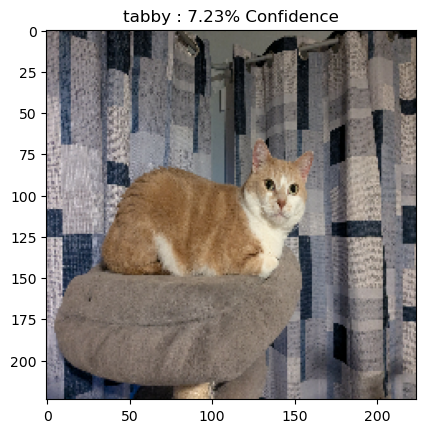

In [10]:
# show image
plt.figure() 
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs) # Get the class label and confidence score
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100)) # determined image class and confidence
plt.show()

In [11]:

# print(f"Image: {type(image)}")
# print(image.shape if hasattr(image, 'shape') else "No shape attribute")

# print(f"Label: {type(label)}")
# print(label.shape if hasattr(label, 'shape') else "No shape attribute")

aa.debug_output(image, label)

Image: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 224, 224, 3)
<dtype: 'float32'>
Element 0: Type = <class 'tensorflow.python.framework.ops.EagerTensor'>, dtype = <dtype: 'float32'>
Tuple: <class 'tensorflow.python.framework.ops.EagerTensor'>


Label: <class 'tuple'>
No shape attribute
('n02123045', 'tabby', 0.07227945)


In [26]:
# Set epsilons
epsilons = [0.78] # Epsilon values for perturbation

# set loss function
loss_function_list = ["CategoricalCrossentropy", 
                      "SparseCategoricalCrossentropy",
                      "BinaryCrossentropy",
                      "MeanSquaredError",
                      "CosineSimilarity"]

loss_function = loss_function_list[1] # Select the loss function to use
new_label = ""

if loss_function == "CategoricalCrossentropy":
    loss_object = tf.keras.losses.CategoricalCrossentropy() # Categorical crossentropy loss function    
    image_index = 208 # Index of the label in the ImageNet dataset
    new_label = tf.one_hot(image_index, image_probs.shape[-1]) # One-hot encoding of the label
    new_label = tf.reshape(new_label, (1, image_probs.shape[-1])) # Reshape the label to match the input shape of the model

elif loss_function == "SparseCategoricalCrossentropy":
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy() # Sparse categorical crossentropy loss function
    new_label = (label[-1],)
    
elif loss_function == "BinaryCrossentropy":
    loss_object = tf.keras.losses.BinaryCrossentropy() # Binary crossentropy loss function
    
elif loss_function == "MeanSquaredError":
    loss_object = tf.keras.losses.MeanSquaredError() # Mean squared error loss function
    
elif loss_function == "CosineSimilarity":
    loss_object = tf.keras.losses.CosineSimilarity() # Cosine similarity loss function
    

print(loss_function)
print(loss_object)
print(new_label)

SparseCategoricalCrossentropy
<LossFunctionWrapper(<function sparse_categorical_crossentropy at 0x151dcd990>, kwargs={'from_logits': False, 'ignore_class': None})>
(0.07227945,)


In [23]:
# Generate adversarial images
fgsm_image = aa.FGSM(image, new_label, model, loss_object, epsilons)
#pgd_image = aa.PGD(image, label, model)
#cw_image = aa.CW(image, label, model)
#jsma_image = aa.JSMA(image, label, model)
#deepfool_image = aa.DeepFool(image, label, model)


Image: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 224, 224, 3)
<dtype: 'float32'>
Element 0: Type = <class 'tensorflow.python.framework.ops.EagerTensor'>, dtype = <dtype: 'float32'>
Tuple: <class 'tensorflow.python.framework.ops.EagerTensor'>


Label: <class 'tensorflow.python.framework.ops.EagerTensor'>
(1,)
tf.Tensor([0.07227945], shape=(1,), dtype=float32)
Label shape: (1,)
Prediction shape: (1, 1000)
Image shape: (1, 224, 224, 3)
FGSM image shape: (1, 224, 224, 3)
Label shape: (1,)


Image shape: (1, 224, 224, 3)
FGSM image shape: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.995098].


Image: <class 'numpy.ndarray'>
(1, 224, 224, 3)
float32
Element 0: Type = <class 'numpy.ndarray'>, dtype = float32
Tuple: <class 'numpy.ndarray'>


Label: <class 'tuple'>
No shape attribute
('n02123045', 'tabby', 0.07227945)
Image: <class 'numpy.ndarray'>
(1, 224, 224, 3)
float32
Element 0: Type = <class 'numpy.ndarray'>, dtype = float32
Tuple: <class 'numpy.ndarray'>


Label: <class 'tuple'>
No shape attribute
('n03998194', 'prayer_rug', 0.46034196)
Original Label: ('n02123045', 'tabby', 0.07227945)
Adversarial Label: ('n03998194', 'prayer_rug', 0.46034196)


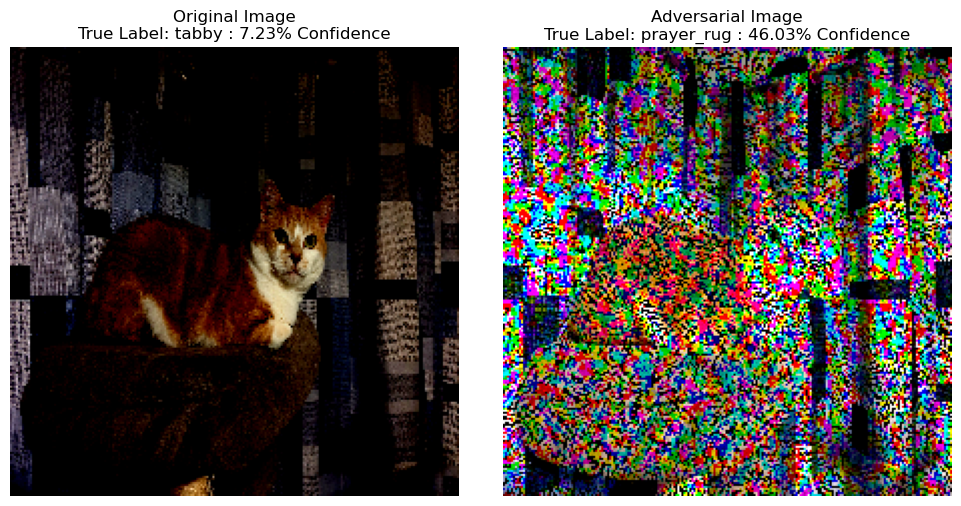

In [24]:
# Visualize the adverarial examples
aa.visualize_adversarial_examples(image, fgsm_image, labels, model)
# aa.visualize_adversarial_examples(image, pgd_image, label, model)
# aa.visualize_adversarial_examples(image, cw_image, label, model)
# aa.visualize_adversarial_examples(image, jsma_image, label, model)
# aa.visualize_adversarial_examples(image, deepfool_image, label, model)


In [ ]:
# Save the original image
aa.save_adversarial_images(image, image, label, 'output/original')

# Save the adversarial images
aa.save_adversarial_images(image, fgsm_image, label, 'output/fgsm')
# aa.save_adversarial_images(image, pgd_image, label, 'output/pgd')
# aa.save_adversarial_images(image, cw_image, label, 'output/cw')
# aa.save_adversarial_images(image, jsma_image, label, 'output/jsma')
# aa.save_adversarial_images(image, deepfool_image, label, 'output/deepfool')
    

2025-04-03 16:45:08.014363: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.
2025-04-03 16:45:08.014395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: slice index 1 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/